# Final Project

## Predict whether a mammogram mass is benign or malignant

We'll be using the "mammographic masses" public dataset from the UCI repository (source: https://archive.ics.uci.edu/ml/datasets/Mammographic+Mass)

This data contains 961 instances of masses detected in mammograms, and contains the following attributes:


   1. BI-RADS assessment: 1 to 5 (ordinal)  
   2. Age: patient's age in years (integer)
   3. Shape: mass shape: round=1 oval=2 lobular=3 irregular=4 (nominal)
   4. Margin: mass margin: circumscribed=1 microlobulated=2 obscured=3 ill-defined=4 spiculated=5 (nominal)
   5. Density: mass density high=1 iso=2 low=3 fat-containing=4 (ordinal)
   6. Severity: benign=0 or malignant=1 (binominal)
   
BI-RADS is an assesment of how confident the severity classification is; it is not a "predictive" attribute and so we will discard it. The age, shape, margin, and density attributes are the features that we will build our model with, and "severity" is the classification we will attempt to predict based on those attributes.

Although "shape" and "margin" are nominal data types, which sklearn typically doesn't deal with well, they are close enough to ordinal that we shouldn't just discard them. The "shape" for example is ordered increasingly from round to irregular.

A lot of unnecessary anguish and surgery arises from false positives arising from mammogram results. If we can build a better way to interpret them through supervised machine learning, it could improve a lot of lives.

## Your assignment

Build a Multi-Layer Perceptron and train it to classify masses as benign or malignant based on its features.

The data needs to be cleaned; many rows contain missing data, and there may be erroneous data identifiable as outliers as well.

Remember to normalize your data first! And experiment with different topologies, optimizers, and hyperparameters.

I was able to achieve over 80% accuracy - can you beat that?

## Prepare the data

In [159]:
!ls

Datasets                             include
DeepLearningProjectImprovement.ipynb lib
bin                                  pyvenv.cfg
etc                                  share


In [160]:
from pathlib import Path

def check_path_exists(filepath):
    return Path(filepath).exists()

check_path_exists("Datasets/mammographic+mass/mammographic_masses.data")

True

In [161]:
import pandas as pd

filepath = "Datasets/mammographic+mass/mammographic_masses.data"
masses_data = pd.read_csv(filepath)
masses_data.head()

,5,67,3,5.1,3.1,1
0,4,43,1,1,?,1
1,5,58,4,5,3,1
2,4,28,1,1,3,0
3,5,74,1,5,?,1
4,4,65,1,?,3,0


In [162]:
masses_data = pd.read_csv(filepath, na_values=["?"], names= ['BI-RADS', 'age', 'shape', 'margin', 'density', 'severity'])
masses_data.head()

,BI-RADS,age,shape,margin,density,severity
0,5.0,67.0,3.0,5.0,3.0,1
1,4.0,43.0,1.0,1.0,NaN,1
2,5.0,58.0,4.0,5.0,3.0,1
3,4.0,28.0,1.0,1.0,3.0,0
4,5.0,74.0,1.0,5.0,NaN,1


In [163]:
masses_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 961 entries, 0 to 960
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   BI-RADS   959 non-null    float64
 1   age       956 non-null    float64
 2   shape     930 non-null    float64
 3   margin    913 non-null    float64
 4   density   885 non-null    float64
 5   severity  961 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 45.2 KB


In [164]:
masses_data.loc[(masses_data['age'].isnull()) |
              (masses_data['shape'].isnull()) |
              (masses_data['margin'].isnull()) |
              (masses_data['density'].isnull())]

,BI-RADS,age,shape,margin,density,severity
1,4.0,43.0,1.0,1.0,NaN,1
4,5.0,74.0,1.0,5.0,NaN,1
5,4.0,65.0,1.0,NaN,3.0,0
6,4.0,70.0,NaN,NaN,3.0,0
7,5.0,42.0,1.0,NaN,3.0,0
...,...,...,...,...,...,...
778,4.0,60.0,NaN,4.0,3.0,0
819,4.0,35.0,3.0,NaN,2.0,0
824,6.0,40.0,NaN,3.0,4.0,1
884,5.0,NaN,4.0,4.0,3.0,1


### A note on missing data
- MCAR (Missing Completely at Random): missing data is randomly distributed, meaning it is okay to drop
- MAR (Missing at Random): missingness depends on other observed variables so imputation is needed
- MNAR (Missing Not at Random): Missingness depedns on unobserved variables or the values itself, so dropping leads to bias

#### Visual Inspection

<Axes: >

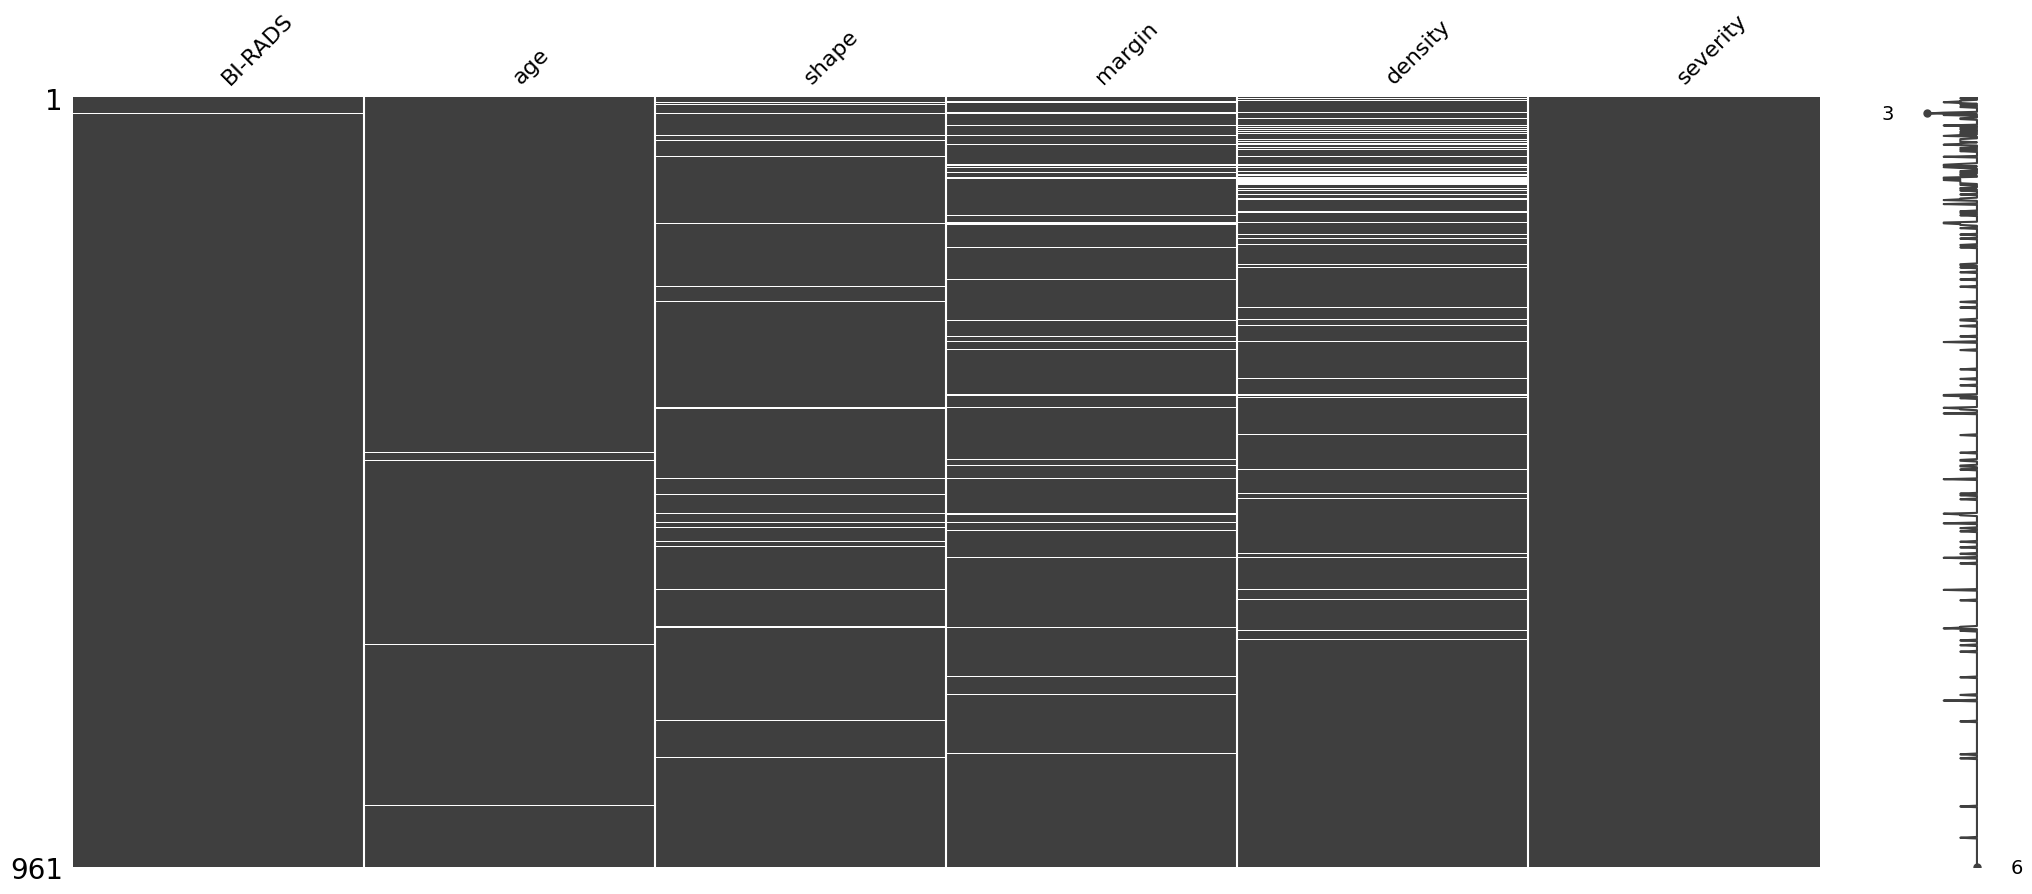

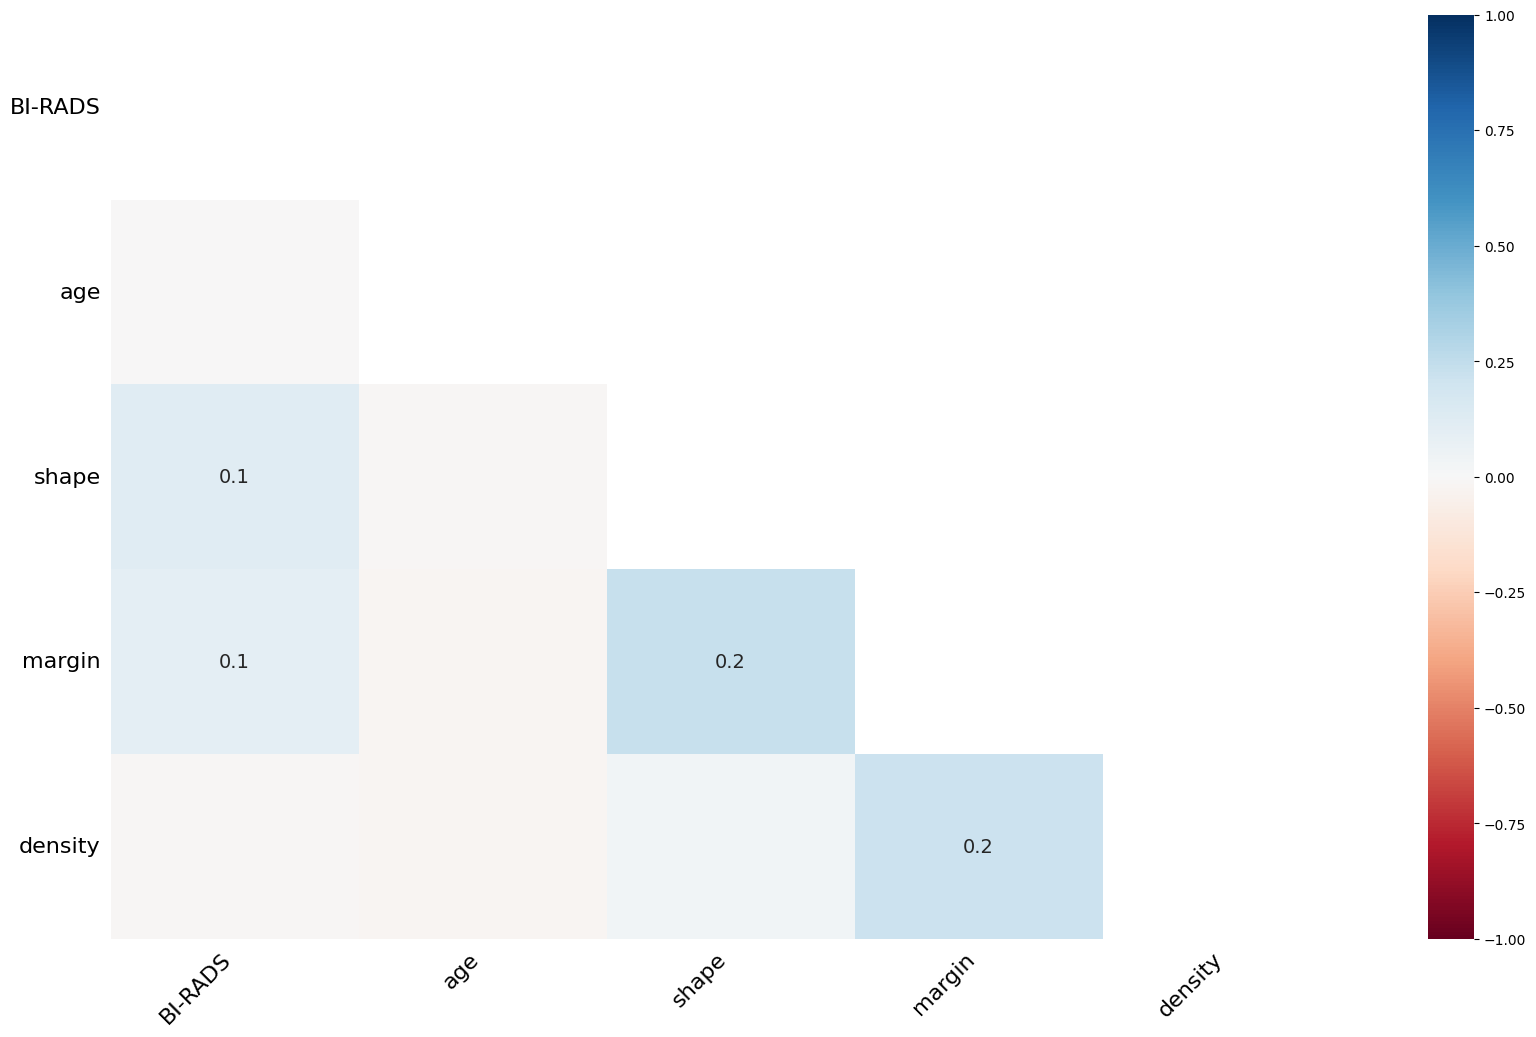

In [165]:
import missingno as msno
import pandas as pd

msno.matrix(masses_data)
msno.heatmap(masses_data)


**Breakdown**
- White lines = missing values
- Black = present values
From here we can see that margin and density have significant missingness and that some rows have multiple missing values.

Correlation plot: 
- positive correlation between two variables means that when one is missing, the other tends to be missing too. We can see from this plot that there is a slight correlation between some columns suggesting MAR, but no strong evidence of MNAR.

Possible solution: imputation 

But I will explore further

**Correlation with Missing Flags**

What this adds: Unlike missingno, correlation with missing flags tests whether the missingness in one column is related to the actual values in other columns, not just missingness in other columns 



In [166]:
import warnings 
columns = ['BI-RADS', 'age', 'shape', 'margin', 'density', 'severity']
for col in columns:
    for target in columns:
        if col != target:
            missing_flag = masses_data[target].isnull().astype(int) #a series 
            series = masses_data[col]
            valid_idx = series.notnull() & missing_flag.notnull()

            with warnings.catch_warnings():
                warnings.simplefilter("ignore", category=RuntimeWarning)
                corr = series[valid_idx].corr(missing_flag[valid_idx])

            if not pd.isna(corr):
                print(f"Correlation between {col} and missingness in {target}: {corr:.3f}")


Correlation between BI-RADS and missingness in age: 0.018
Correlation between BI-RADS and missingness in shape: -0.055
Correlation between BI-RADS and missingness in margin: -0.031
Correlation between BI-RADS and missingness in density: -0.047
Correlation between age and missingness in BI-RADS: 0.011
Correlation between age and missingness in shape: 0.015
Correlation between age and missingness in margin: 0.003
Correlation between age and missingness in density: -0.102
Correlation between shape and missingness in BI-RADS: 0.034
Correlation between shape and missingness in age: 0.064
Correlation between shape and missingness in margin: -0.116
Correlation between shape and missingness in density: -0.146
Correlation between margin and missingness in BI-RADS: 0.025
Correlation between margin and missingness in age: 0.048
Correlation between margin and missingness in shape: 0.109
Correlation between margin and missingness in density: -0.107
Correlation between density and missingness in BI-

There doesn't seem to be significant correlation here. Possibly, with |corr|>=0.1 it would suggest some non-random missingness but nothing to be cautious about dropping rows. 

**Little's MCAR Test**
- Null hypothesis: The missingness in the dataset is completely at random (MCAR)
- If P < 0.05 --> reject MCAR --> data is likely MAR or MNAR
- If P >= 0.05 --> insufficient evidence to reject MCAR

**IMPORTANT DISCRETION**
Little's MCAR Test is accurate only if the data follows the test's assumptions:
1. Multivariate normality
2. Sufficient group size per missingness pattern
3. Data type appropiatness (continuous numeric)
4. Large enough sample size

**Multivariate normality**: Little's test relies on Mahalanobis distances, which assume normally distributed features

**Sufficient group size per missingness pattern**: Sparse groups distort the test statistic

**Data type appropiatness**: Mahalanobis distance doesn't work well with categorical variables

**Large enough sample size**: Chi-squared approximation becomes unstable with small n

**Testing the Assumptions**
1. *Multivariate Normality*: If |skew| > 2 or |kurtosis - 3| > 4, the data is likely non-normal
2. *Sufficient group sizes for missingness patterns*: We want at least 2-5 rows per pattern for the test to be meaningful
3. *Data types* : as mentioned above, we will test by checking the datatypes of the columns
4. *Check sample size*: to make sure we have enough rows (100-200 and multiple patterns with >= 5 rows)

In [167]:
from scipy.stats import skew, kurtosis

for col in masses_data.select_dtypes(include="number").columns:
    print(f"{col}: skew={skew(masses_data[col].dropna()):.2f}, kurtosis={kurtosis(masses_data[col].dropna(), fisher=False):.2f}")

BI-RADS: skew=23.84, kurtosis=680.76
age: skew=-0.21, kurtosis=2.68
shape: skew=-0.22, kurtosis=1.40
margin: skew=-0.04, kurtosis=1.37
density: skew=-2.88, kurtosis=14.64
severity: skew=0.15, kurtosis=1.02


From here we can see that the normality assumption for Mahalanobis distance is violated, therefore Little's MCAR test may produce unreliable p-values but I included a function for the test for future reference. 

**Implementation into Python**
1. **Drop fully observed or fully missing columns**: we want to test if missingness in the data is completely at random, therefore, a column with no missing values is irrelevant to the test, and a column that is entirely missing can't be used as there is no data to compare
2. **Identify all unique missingness patterns**: Each row has a pattern of missing (1) and not missing (0) across columns, and these patterns define groups of rows with the same type of missingness.
3. **For each missigness pattern**: Extract rows that match that pattern, and compute group size which is what will be used to weight each groups contribution to the test statistic. Then compute a group mean giving you the mean of observed values in this group, and a pooled mean, which is the overall average from all rows. The latter is the benchmark. If missigness is random, then each group's mean should be close to this overall mean. Finally, we compute the test statistic, which is a Mahalanobis distance between the group and pooled mean. Each group contributes to the chi-squared statistic by how far its mean deviates from the overall mean, therefore accounting for covariance structure.
4. **Combine into total chi-squared and degrees of freedom**: we sum the contribution from all valid groups giving a test_stat (total chi-squared value) and df_total (total degrees of freedom, which is on the number of observed columns in all groups)
5. **Compute the p-value**: Using the chi-squared distribution. 

In [168]:
import numpy as np
import pandas as pd
from scipy.stats import chi2

def little_mcar_test(df):
    df = df.copy()
    df = df.select_dtypes(include=[np.number]) 

    df = df.loc[:, df.isnull().sum() > 0]
    df = df.loc[:, df.isnull().sum() < len(df)]

    patterns = df.isnull().astype(int)
    patterns['pattern_id'] = patterns.apply(lambda row: ''.join(row.astype(str)), axis=1)
    df['pattern_id'] = patterns['pattern_id']

    pattern_groups = df.groupby('pattern_id')

    pooled_mean = df.drop(columns='pattern_id').mean(skipna=True)
    pooled_cov = df.drop(columns='pattern_id').cov()

    test_stat = 0
    df_total = 0

    for pattern_id, group in pattern_groups:
        n_g = len(group)
        if n_g < 2:
            continue

        sub_df = group.drop(columns='pattern_id')
        observed = sub_df.dropna(axis=1, how='any')
        if observed.shape[1] == 0:
            continue

        mean_g = observed.mean()
        diff = (mean_g - pooled_mean[observed.columns]).values
        cov_g = pooled_cov.loc[observed.columns, observed.columns].values

        try:
            inv_cov = np.linalg.inv(cov_g)
        except np.linalg.LinAlgError:
            continue

        chi_square = n_g * diff.T @ inv_cov @ diff
        test_stat += chi_square
        df_total += len(observed.columns)

    p_value = 1 - chi2.cdf(test_stat, df_total)

    return {
        "chi2": round(test_stat, 3),
        "df": df_total,
        "p_value": round(p_value, 5),
        "MCAR": p_value >= 0.05
    }

In [169]:
result = little_mcar_test(masses_data)
print(result)

{'chi2': np.float64(80.017), 'df': 30, 'p_value': np.float64(0.0), 'MCAR': np.False_}


**Logistic Regression on Missingness**
We want to model whether missing values are predictable from other values. If so, this confirms the data is Missing at Random 

In [172]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.metrics import roc_auc_score

def logistic_missingness_analysis(df, predictors=None):
    results = []

    if predictors is None:
        predictors = df.select_dtypes(include='number').dropna(axis=1).columns.tolist()

    for target in df.columns:
        if df[target].isnull().sum() == 0:
            continue 

        print(f"\n🔍 Analyzing missingness in '{target}'...")
        df_copy = df.copy()
        df_copy[f'{target}_missing'] = df_copy[target].isnull().astype(int)


        cols_to_use = predictors.copy()
        if target in cols_to_use:
            cols_to_use.remove(target)  
            
        model_data = df_copy[cols_to_use + [f'{target}_missing']].dropna()

        if len(model_data) < 30:
            print("❗ Skipping due to too few complete cases.")
            continue

        X = model_data[cols_to_use]
        y = model_data[f'{target}_missing']

        X = sm.add_constant(X)

        try:
            model = sm.Logit(y, X).fit(disp=False)

            # Evaluate model fit
            y_pred_prob = model.predict(X)
            auc = roc_auc_score(y, y_pred_prob)

            print(model.summary())
            print(f"✅ AUC for predicting missingness in '{target}': {auc:.2f}")

            # Store results
            results.append({
                'target': target,
                'n_samples': len(model_data),
                'significant_predictors': model.pvalues[model.pvalues < 0.05].index.tolist(),
                'AUC': auc
            })

        except Exception as e:
            print(f"Model failed for '{target}': {e}")

    return pd.DataFrame(results)

In [173]:
results_df = logistic_missingness_analysis(masses_data)
results_df


🔍 Analyzing missingness in 'BI-RADS'...
                           Logit Regression Results                           
Dep. Variable:        BI-RADS_missing   No. Observations:                  961
Model:                          Logit   Df Residuals:                      959
Method:                           MLE   Df Model:                            1
Date:                Wed, 06 Aug 2025   Pseudo R-squ.:               0.0003823
Time:                        16:23:42   Log-Likelihood:                -14.342
converged:                       True   LL-Null:                       -14.348
Covariance Type:            nonrobust   LLR p-value:                    0.9166
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -6.2442      1.001     -6.238      0.000      -8.206      -4.282
severity       0.1483      1.416      0.105      0.917      -2.626       2.923
✅ AUC for p

,target,n_samples,significant_predictors,AUC
0,BI-RADS,961,[const],0.518509
1,shape,961,[const],0.539247
2,margin,961,"[const, severity]",0.623095
3,density,961,"[const, severity]",0.594246


From here we can see that only margin and density have significant predictors, that being severity, so for this we will need to impute with the following strategy:
1. If missing values are only in MCAR columns we are safe to drop those rows
2. If there are missing values in MAR or MCAR and MAR then we must impute

From this analysis we can see that our MCAR columns are BI-RADS and shape, and our MAR columns are margin and density. So we will drop rows that are missing only in MCAR columns and are fully observed in MAR columns 

In [174]:

mcar_cols = ['BI-RADS', 'shape']
mar_cols = ['margin', 'density']

mcar_only_missing = masses_data[mcar_cols].isnull().any(axis=1)
mar_fully_present = masses_data[mar_cols].notnull().all(axis=1)

rows_to_drop = mcar_only_missing & mar_fully_present

masses_data_cleaned = masses_data[~rows_to_drop]

**Imputation**

To decide whether to use a linear or nonlinear imputer, we must determine if the data models the former or the latter. 

**Visual Inspection**

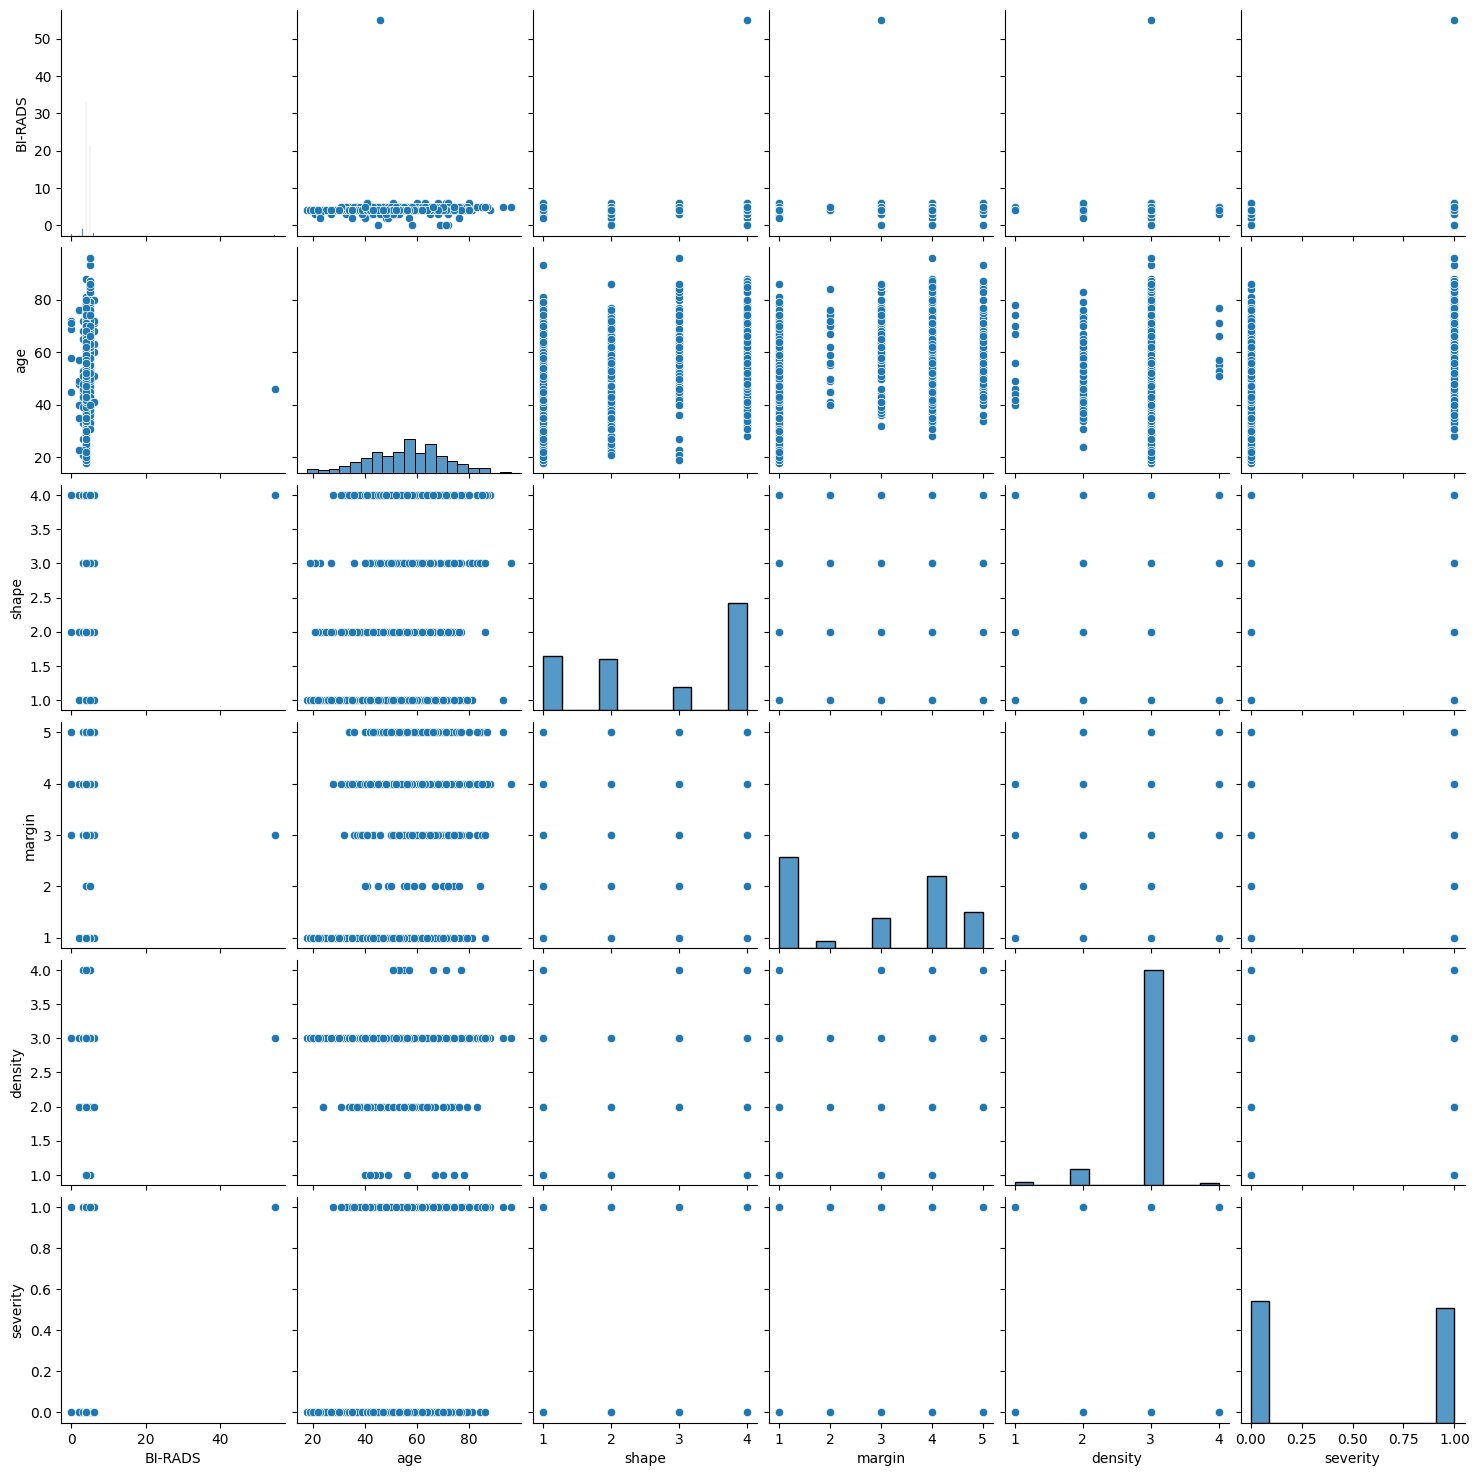

In [175]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.pairplot(masses_data.dropna())
plt.show()

The prescence of straight lines likely shows that this data has little relationships.

In [176]:
masses_data.dropna(inplace=True)
masses_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 830 entries, 0 to 960
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   BI-RADS   830 non-null    float64
 1   age       830 non-null    float64
 2   shape     830 non-null    float64
 3   margin    830 non-null    float64
 4   density   830 non-null    float64
 5   severity  830 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 45.4 KB


In [177]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

features = ['age', 'shape', 'margin', 'density']
target = 'severity'

X = masses_data[features]
y = masses_data[target]

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [178]:
import torch

print("Is MPS (Apple GPU) available:", torch.backends.mps.is_available())
print("Is MPS built into this PyTorch:", torch.backends.mps.is_built())

Is MPS (Apple GPU) available: True
Is MPS built into this PyTorch: True


In [179]:
if torch.backends.mps.is_available():
    device = torch.device("mps") 
else:
    device = torch.device("cpu")

print("Using device:", device)

Using device: mps


In [180]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, average_precision_score


device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")


x_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values.reshape(-1, 1), dtype=torch.float32)

x_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values.reshape(-1, 1), dtype=torch.float32)


train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

class BinaryClassifier(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

model = BinaryClassifier(X_train.shape[1]).to(device)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


num_epochs = 100
best_val_loss = float('inf')
patience = 5
epochs_without_improvement = 0

train_losses = []
val_losses = []
val_accuracies = []
val_precisions = []
val_recalls = []
val_aucs = []
pr_aucs = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        loss = criterion(preds, yb)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)

    model.eval()
    val_loss = 0.0
    all_preds = []
    all_true = []
    all_probs = []

    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)

            val_loss += criterion(preds, yb).item()

            probs = torch.sigmoid(preds).squeeze()
            predicted = (preds >= 0.5).float()

            all_preds.extend(predicted.cpu().numpy())
            all_true.extend(yb.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = accuracy_score(all_true, all_preds)
    val_precision = precision_score(all_true, all_preds, zero_division=0)
    val_recall = recall_score(all_true, all_preds, zero_division=0)
    val_auc = roc_auc_score(all_true, all_probs)
    val_pr_auc = average_precision_score(all_true, all_probs)

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)
    val_precisions.append(val_precision)
    val_recalls.append(val_recall)
    val_aucs.append(val_auc)
    pr_aucs.append(val_pr_auc)

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0
        best_model_state = model.state_dict()
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f"Stopping early at epoch {epoch + 1}")
        model.load_state_dict(best_model_state)
        break

    print(f"Epoch {epoch + 1:2d} | "
          f"Train Loss: {avg_train_loss:.4f} | "
          f"Val Loss: {avg_val_loss:.4f} | "
          f"Val Acc: {val_accuracy:.4f} | "
          f"Precision: {val_precision:.4f} | "
          f"Recall: {val_recall:.4f} | "
          f"AUC: {val_auc:.4f}")

Epoch  1 | Train Loss: 1.0045 | Val Loss: 0.7008 | Val Acc: 0.5489 | Precision: 0.0000 | Recall: 0.0000 | AUC: 0.4493
Epoch  2 | Train Loss: 0.6943 | Val Loss: 0.6597 | Val Acc: 0.6015 | Precision: 0.5310 | Recall: 1.0000 | AUC: 0.8579
Epoch  3 | Train Loss: 0.6635 | Val Loss: 0.6752 | Val Acc: 0.4511 | Precision: 0.4511 | Recall: 1.0000 | AUC: 0.8605
Epoch  4 | Train Loss: 0.6540 | Val Loss: 0.6342 | Val Acc: 0.8195 | Precision: 0.7432 | Recall: 0.9167 | AUC: 0.8381
Epoch  5 | Train Loss: 0.6588 | Val Loss: 0.6223 | Val Acc: 0.7669 | Precision: 0.7377 | Recall: 0.7500 | AUC: 0.8336
Epoch  6 | Train Loss: 0.6313 | Val Loss: 0.6125 | Val Acc: 0.7594 | Precision: 0.6556 | Recall: 0.9833 | AUC: 0.8546
Epoch  7 | Train Loss: 0.6186 | Val Loss: 0.5956 | Val Acc: 0.8120 | Precision: 0.7108 | Recall: 0.9833 | AUC: 0.8534
Epoch  8 | Train Loss: 0.6058 | Val Loss: 0.5750 | Val Acc: 0.8271 | Precision: 0.7342 | Recall: 0.9667 | AUC: 0.8438
Epoch  9 | Train Loss: 0.6093 | Val Loss: 0.5673 | Val A

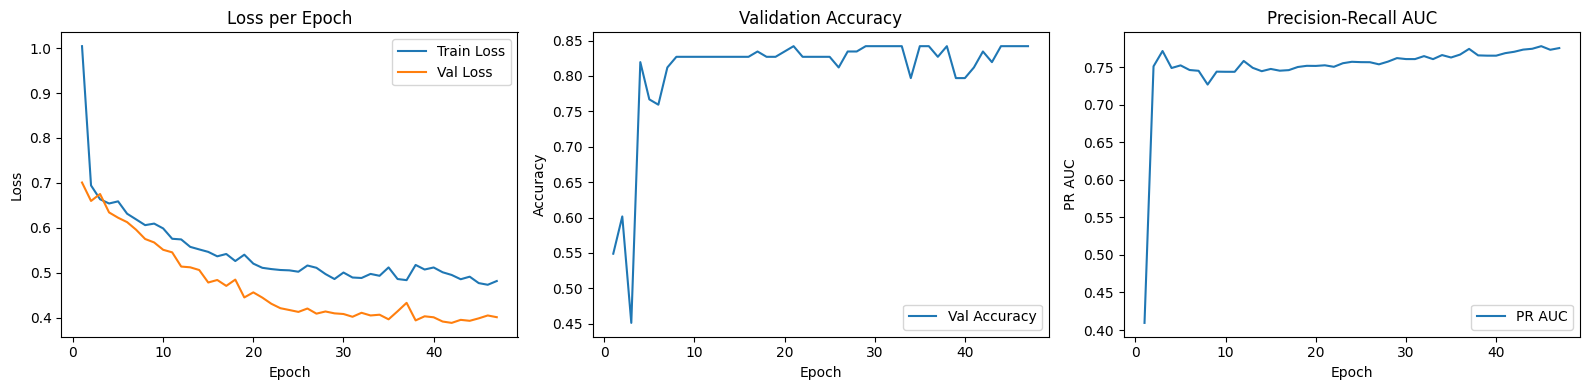

In [181]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(16, 4))

# Training and Validation Loss
plt.subplot(1, 3, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Val Loss')
plt.title("Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Validation Accuracy
plt.subplot(1, 3, 2)
plt.plot(epochs, val_accuracies, label='Val Accuracy')
plt.title("Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# PR AUC
plt.subplot(1, 3, 3)
plt.plot(epochs, pr_aucs, label='PR AUC')
plt.title("Precision-Recall AUC")
plt.xlabel("Epoch")
plt.ylabel("PR AUC")
plt.legend()

plt.tight_layout()
plt.show()

In [182]:
import optuna
import torch
import torch.nn as nn
import torch.optim as optim
def objective(trial):
    n_layers = trial.suggest_int("n_layers", 1, 3)
    hidden_dim = trial.suggest_int("hidden_dim", 16, 128)
    dropout_rate = trial.suggest_float("dropout", 0.0, 0.5)
    lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True)
    activation_name = trial.suggest_categorical("activation", ["relu", "leaky_relu", "tanh"])

    activations = {
        "relu": nn.ReLU(),
        "leaky_relu": nn.LeakyReLU(),
        "tanh": nn.Tanh()
    }
    activation_fn = activations[activation_name]

    class DynamicNet(nn.Module):
        def __init__(self):
            super().__init__()
            layers = []

            input_dim = x_train_tensor.shape[1]
            for _ in range(n_layers):
                layers.append(nn.Linear(input_dim, hidden_dim))
                layers.append(activation_fn)
                layers.append(nn.Dropout(dropout_rate))
                input_dim = hidden_dim

            layers.append(nn.Linear(hidden_dim, 1))
            layers.append(nn.Sigmoid())

            self.model = nn.Sequential(*layers)

        def forward(self, x):
            return self.model(x)

    model = DynamicNet().to(device)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    model.train()
    for epoch in range(10):  
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb).squeeze()
            loss = criterion(preds, yb.view(-1))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    model.eval()
    all_preds = []
    all_true = []
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb).squeeze()
            predicted = (preds >= 0.5).float()
            all_preds.extend(predicted.cpu().numpy())
            all_true.extend(yb.cpu().numpy())

    acc = accuracy_score(all_true, all_preds)
    return acc

In [183]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)

print("Best hyperparameters:", study.best_params)

[I 2025-08-06 16:25:20,682] A new study created in memory with name: no-name-54c7a9d0-73f9-4caf-b1af-69baf64381eb
[I 2025-08-06 16:25:20,954] Trial 0 finished with value: 0.5488721804511278 and parameters: {'n_layers': 1, 'hidden_dim': 82, 'dropout': 0.031697102022369084, 'lr': 3.8432257990046224e-05, 'activation': 'tanh'}. Best is trial 0 with value: 0.5488721804511278.
[I 2025-08-06 16:25:21,177] Trial 1 finished with value: 0.8045112781954887 and parameters: {'n_layers': 2, 'hidden_dim': 74, 'dropout': 0.1809206077057019, 'lr': 0.00014556987903751245, 'activation': 'tanh'}. Best is trial 1 with value: 0.8045112781954887.
[I 2025-08-06 16:25:21,352] Trial 2 finished with value: 0.45112781954887216 and parameters: {'n_layers': 1, 'hidden_dim': 19, 'dropout': 0.32721136295178527, 'lr': 0.00028520639588740633, 'activation': 'relu'}. Best is trial 1 with value: 0.8045112781954887.
[I 2025-08-06 16:25:21,608] Trial 3 finished with value: 0.45112781954887216 and parameters: {'n_layers': 3,

Best hyperparameters: {'n_layers': 3, 'hidden_dim': 106, 'dropout': 0.413628044223138, 'lr': 0.0018693071699019395, 'activation': 'tanh'}


In [184]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, average_precision_score
import matplotlib.pyplot as plt

best_params = {
    'n_layers': 3,
    'hidden_dim': 106,
    'dropout': 0.413628044223138,
    'lr': 0.00115,
    'activation': 'tanh'
}

def get_activation(name):
    return {
        'relu': nn.ReLU(),
        'tanh': nn.Tanh(),
        'sigmoid': nn.Sigmoid()
    }[name]


class FinalNet(nn.Module):
    def __init__(self, input_dim):
        super(FinalNet, self).__init__()
        layers = []
        in_dim = input_dim

        for _ in range(best_params['n_layers']):
            layers.append(nn.Linear(in_dim, best_params['hidden_dim']))
            layers.append(get_activation(best_params['activation']))
            layers.append(nn.Dropout(best_params['dropout']))
            in_dim = best_params['hidden_dim']

        layers.append(nn.Linear(in_dim, 1))
        layers.append(nn.Sigmoid())  # For binary classification

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x).squeeze()


model = FinalNet(input_dim=X.shape[1]).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=best_params['lr'])


num_epochs = 100
patience = 5
best_val_loss = float('inf')
epochs_without_improvement = 0


train_losses, val_losses = [], []
val_accuracies, val_precisions, val_recalls, val_aucs, pr_aucs = [], [], [], [], []


for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        loss = criterion(preds, yb.squeeze())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    
    model.eval()
    val_loss = 0.0
    all_preds, all_true, all_probs = [], [], []

    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)

            loss = criterion(preds, yb.squeeze())
            val_loss += loss.item()

            probs = preds.detach().cpu().numpy()
            predicted = (probs >= 0.5).astype(float)

            all_probs.extend(probs)
            all_preds.extend(predicted)
            all_true.extend(yb.cpu().numpy().squeeze())

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    acc = accuracy_score(all_true, all_preds)
    prec = precision_score(all_true, all_preds, zero_division=0)
    rec = recall_score(all_true, all_preds, zero_division=0)
    auc = roc_auc_score(all_true, all_probs)
    pr_auc = average_precision_score(all_true, all_probs)

    val_accuracies.append(acc)
    val_precisions.append(prec)
    val_recalls.append(rec)
    val_aucs.append(auc)
    pr_aucs.append(pr_auc)


    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0
        best_model_state = model.state_dict()
    else:
        epochs_without_improvement += 1

    print(f"Epoch {epoch+1:2d} | Train Loss: {avg_train_loss:.4f} | "
          f"Val Loss: {avg_val_loss:.4f} | Val Acc: {acc:.4f} | "
          f"Prec: {prec:.4f} | Rec: {rec:.4f} | AUC: {auc:.4f} | PR AUC: {pr_auc:.4f}")

    if epochs_without_improvement >= patience:
        print(f"Early stopping at epoch {epoch+1}")
        model.load_state_dict(best_model_state)
        break

# Final model loaded with best weights
model.load_state_dict(best_model_state)

Epoch  1 | Train Loss: 0.6949 | Val Loss: 0.6895 | Val Acc: 0.4511 | Prec: 0.4511 | Rec: 1.0000 | AUC: 0.8240 | PR AUC: 0.6925
Epoch  2 | Train Loss: 0.6849 | Val Loss: 0.6138 | Val Acc: 0.5489 | Prec: 0.0000 | Rec: 0.0000 | AUC: 0.8331 | PR AUC: 0.7185
Epoch  3 | Train Loss: 0.6504 | Val Loss: 0.5578 | Val Acc: 0.8271 | Prec: 0.7342 | Rec: 0.9667 | AUC: 0.8404 | PR AUC: 0.7338
Epoch  4 | Train Loss: 0.6042 | Val Loss: 0.4884 | Val Acc: 0.7519 | Prec: 0.7455 | Rec: 0.6833 | AUC: 0.8420 | PR AUC: 0.7420
Epoch  5 | Train Loss: 0.6025 | Val Loss: 0.4550 | Val Acc: 0.8271 | Prec: 0.7284 | Rec: 0.9833 | AUC: 0.8516 | PR AUC: 0.7457
Epoch  6 | Train Loss: 0.5645 | Val Loss: 0.4026 | Val Acc: 0.8271 | Prec: 0.7403 | Rec: 0.9500 | AUC: 0.8555 | PR AUC: 0.7520
Epoch  7 | Train Loss: 0.5537 | Val Loss: 0.4018 | Val Acc: 0.7895 | Prec: 0.7500 | Rec: 0.8000 | AUC: 0.8553 | PR AUC: 0.7514
Epoch  8 | Train Loss: 0.5596 | Val Loss: 0.4027 | Val Acc: 0.8271 | Prec: 0.7467 | Rec: 0.9333 | AUC: 0.8553 |

<All keys matched successfully>

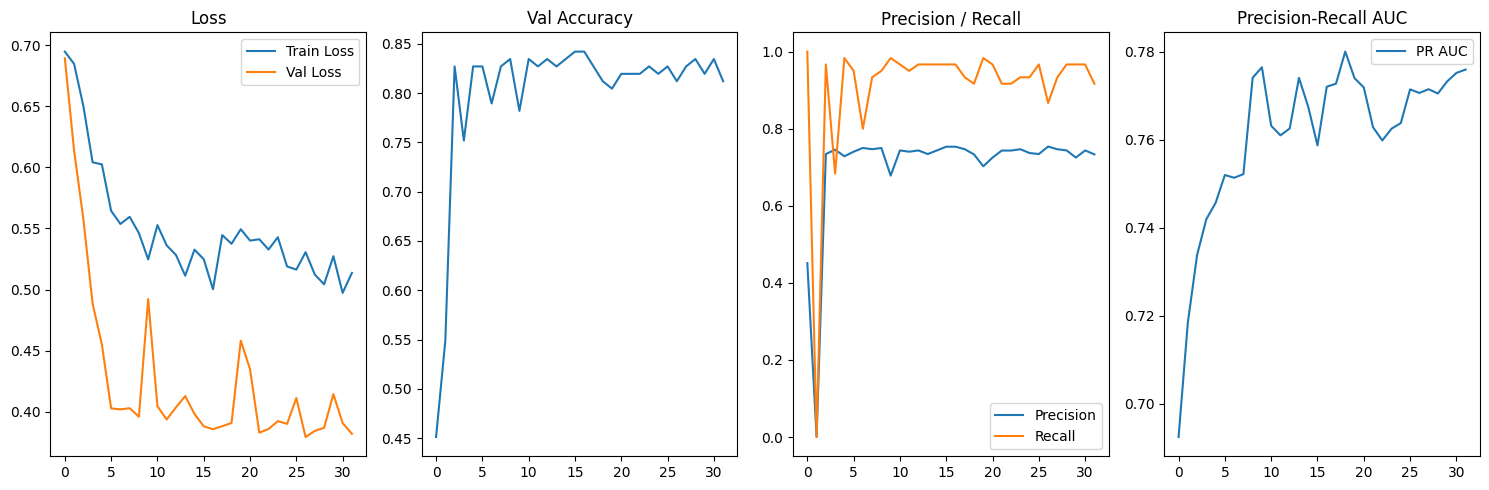

In [185]:
plt.figure(figsize=(15, 5))

# Loss
plt.subplot(1, 4, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title("Loss")
plt.legend()

# Accuracy
plt.subplot(1, 4, 2)
plt.plot(val_accuracies, label='Accuracy')
plt.title("Val Accuracy")

# Precision vs Recall
plt.subplot(1, 4, 3)
plt.plot(val_precisions, label='Precision')
plt.plot(val_recalls, label='Recall')
plt.title("Precision / Recall")
plt.legend()

# PR AUC
plt.subplot(1, 4, 4)
plt.plot(pr_aucs, label='PR AUC')
plt.title("Precision-Recall AUC")
plt.legend()

plt.tight_layout()
plt.show()

In [186]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, average_precision_score

def evaluate_on_test(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        inputs = torch.tensor(X_test.values, dtype=torch.float32).to(device)
        labels = torch.tensor(y_test.values, dtype=torch.float32).to(device)
        outputs = model(inputs).squeeze()
        probs = torch.sigmoid(outputs)
        preds = (probs >= 0.65).float()

    acc = accuracy_score(labels.cpu(), preds.cpu())
    precision = precision_score(labels.cpu(), preds.cpu())
    recall = recall_score(labels.cpu(), preds.cpu())
    roc_auc = roc_auc_score(labels.cpu(), probs.cpu())
    pr_auc = average_precision_score(labels.cpu(), probs.cpu())

    print(f"\n🧪 Test Set Evaluation:")
    print(f"Accuracy:      {acc:.4f}")
    print(f"Precision:     {precision:.4f}")
    print(f"Recall:        {recall:.4f}")
    print(f"ROC AUC:       {roc_auc:.4f}")
    print(f"PR AUC:        {pr_auc:.4f}")


model.load_state_dict(best_model_state)


evaluate_on_test(model, X_test, y_test)


🧪 Test Set Evaluation:
Accuracy:      0.8253
Precision:     0.8158
Recall:        0.8052
ROC AUC:       0.8817
PR AUC:        0.8312
